In [ ]:
from datetime import datetime

In [ ]:
datetime.now().strftime("%Y%m%d %I:%m:%S %p")

In [ ]:
import tensorflow as tf

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import qutip as qt 

In [2]:
from CD_control_optimization.batch_optimizer import BatchOptimizer
from CD_control_optimization.analysis import OptimizationAnalysis


Need tf version 2.3.0 or later. Using tensorflow version: 2.3.1



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
N = 60

In [38]:
N_blocks = 5
alpha = 2 + 1j
N_multistart = 20
epochs = 100
use_displacements = True
no_CD_end = True
initial_states = [qt.tensor(qt.basis(2,0),qt.basis(N,0))]
#target_states = [qt.tensor(qt.basis(2,0), c.zero_logical)]
#target_states = [qt.tensor(qt.basis(2,0),qt.basis(N,1))]
target_states = [qt.tensor(qt.basis(2,0), (qt.coherent(N,alpha) + qt.coherent(N,-alpha)).unit())]
desired_epsilon = 1e-3
term_fid = 1-desired_epsilon
dfid_stop = 1e-8
beta_scale = 4.0
alpha_scale = 0.5
name='Cat Creation'
metadata = {'alpha':alpha}


Need tf version 2.3.0 or later. Using tensorflow version: 2.3.1



In [39]:
opt = BatchOptimizer(initial_states=initial_states, target_states=target_states, N_blocks=N_blocks,term_fid = term_fid,
N_multistart=N_multistart, use_displacements=use_displacements, no_CD_end=no_CD_end, dfid_stop=dfid_stop, name=name, epochs=epochs, beta_scale=beta_scale, alpha_scale=alpha_scale,
metadata = metadata)

In [40]:
opt.parameters

{'optimization_type': 'state transfer',
 'N_multistart': 200,
 'N_blocks': 5,
 'term_fid': 0.999,
 'dfid_stop': 1e-08,
 'no_CD_end': True,
 'name': 'Cat Creation',
 'learning_rate': 0.01,
 'epoch_size': 10,
 'epochs': 100,
 'beta_scale': 4.0,
 'alpha_scale': 0.5,
 'use_displacements': True,
 'comment': '',
 'alpha': (2+1j),
 'N_cav': 60}

In [41]:
all_fids = opt.optimize()

Start time: 2020-10-21 12:01:43 AM
 Epoch: 1 / 100 Max Fid: 0.393272 Avg Fid: 0.060371 Max dFid: 0.339077 Avg dFid: 0.048852 Elapsed time: 0:00:23.401324 Remaing time: 0:38:36.731079

KeyboardInterrupt: 

In [35]:
filename = 'Cat Creation.h5'
analysis = OptimizationAnalysis(filename=filename)
bs = analysis.betas()

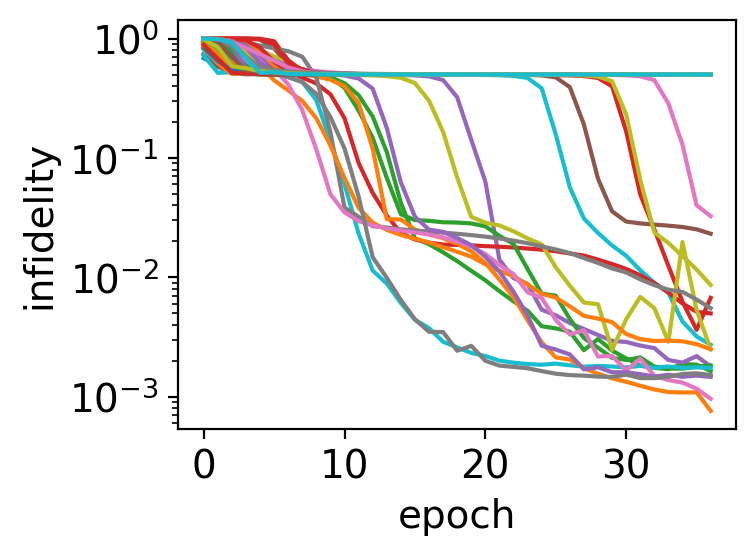

In [36]:
analysis.plot_fidelities()

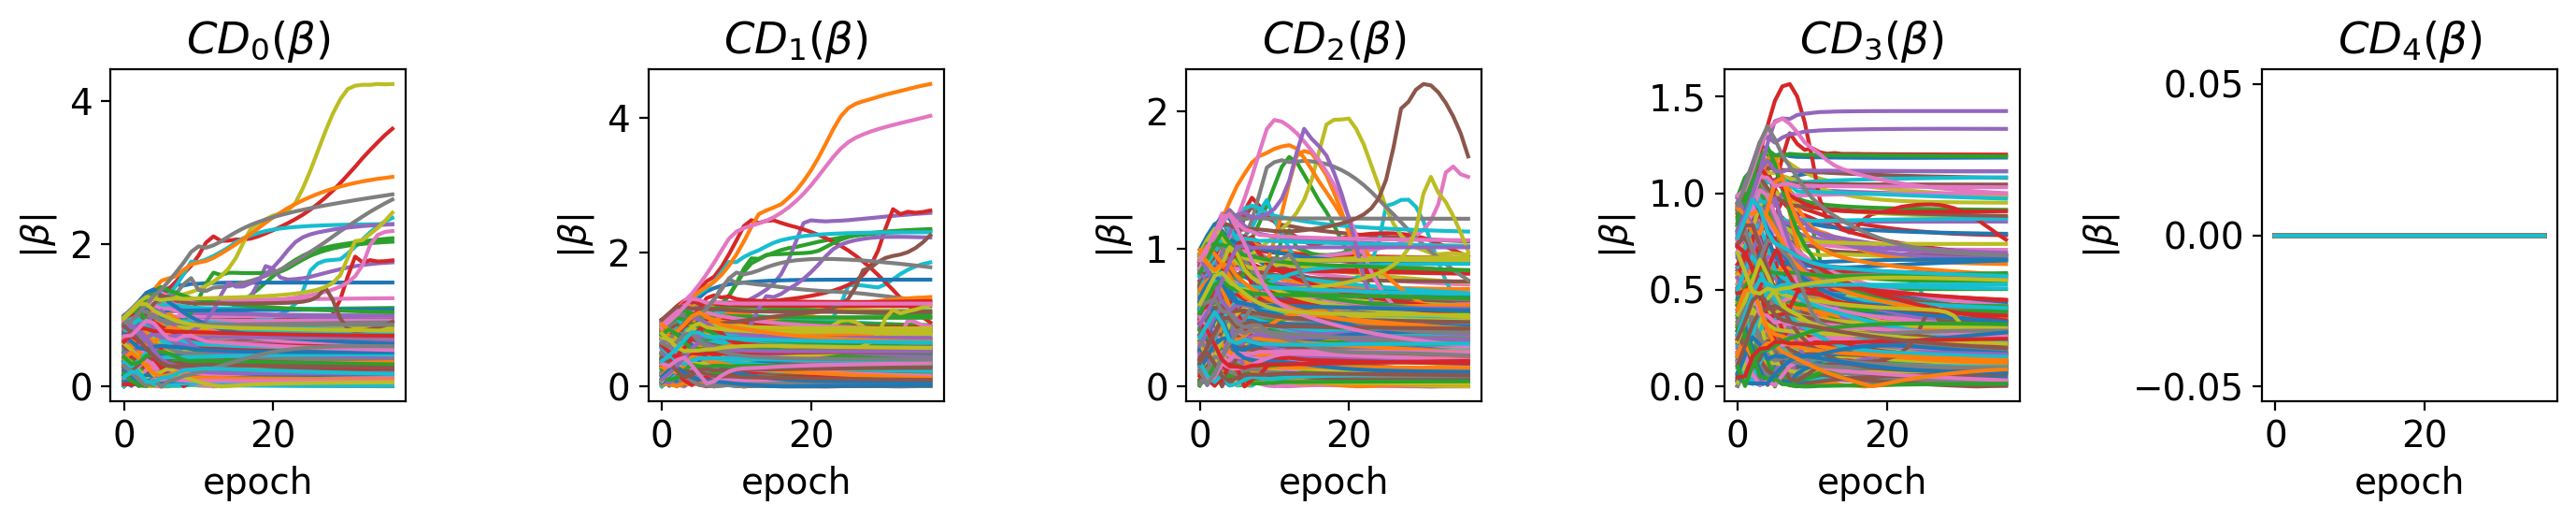

In [37]:
analysis.plot_mag_betas()

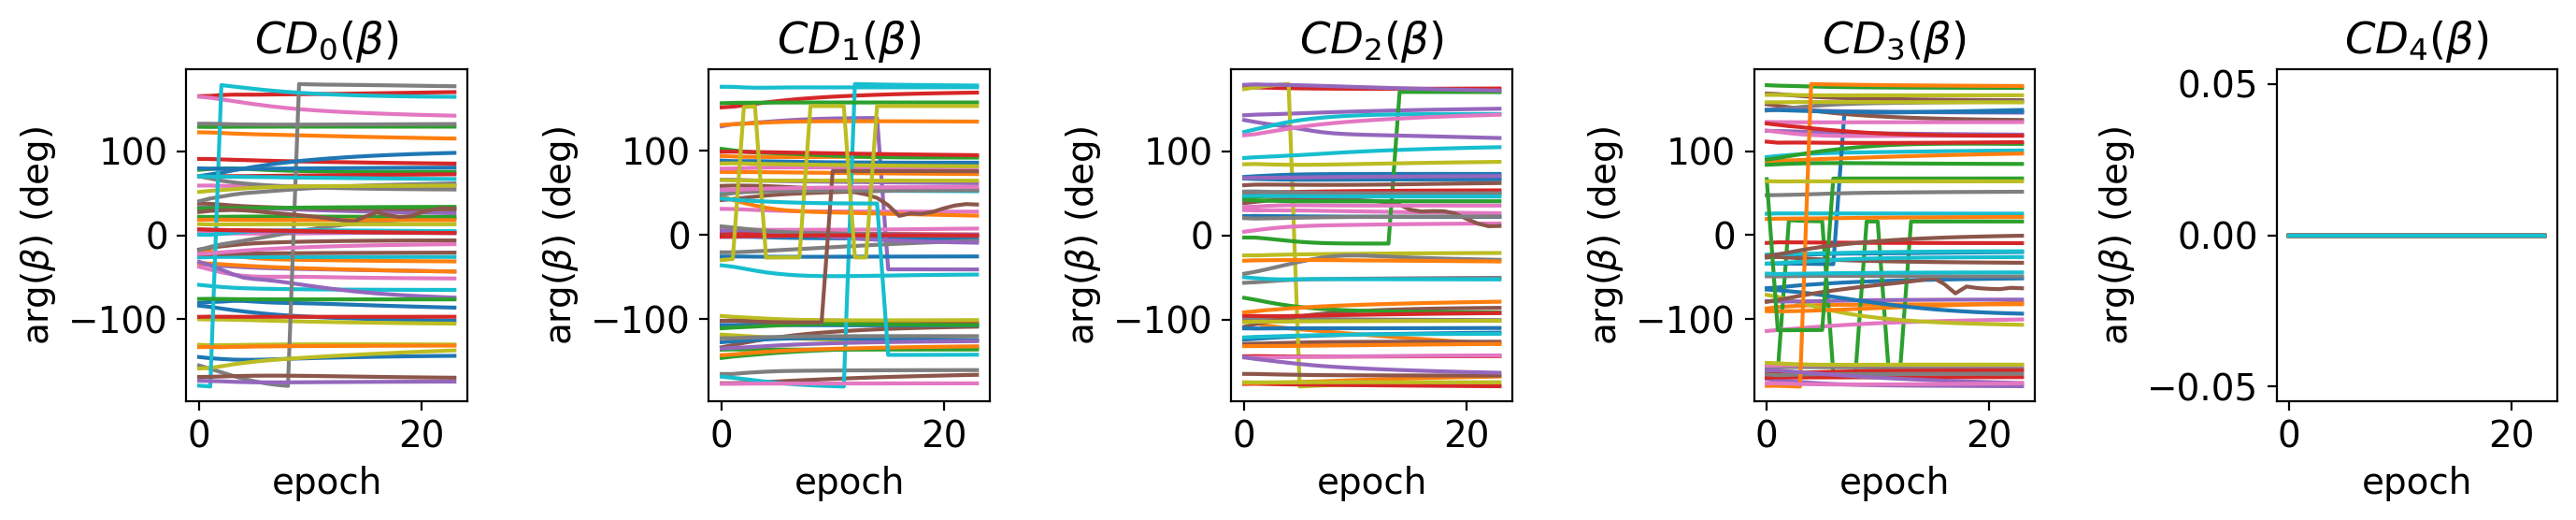

In [20]:
analysis.plot_phase_betas()

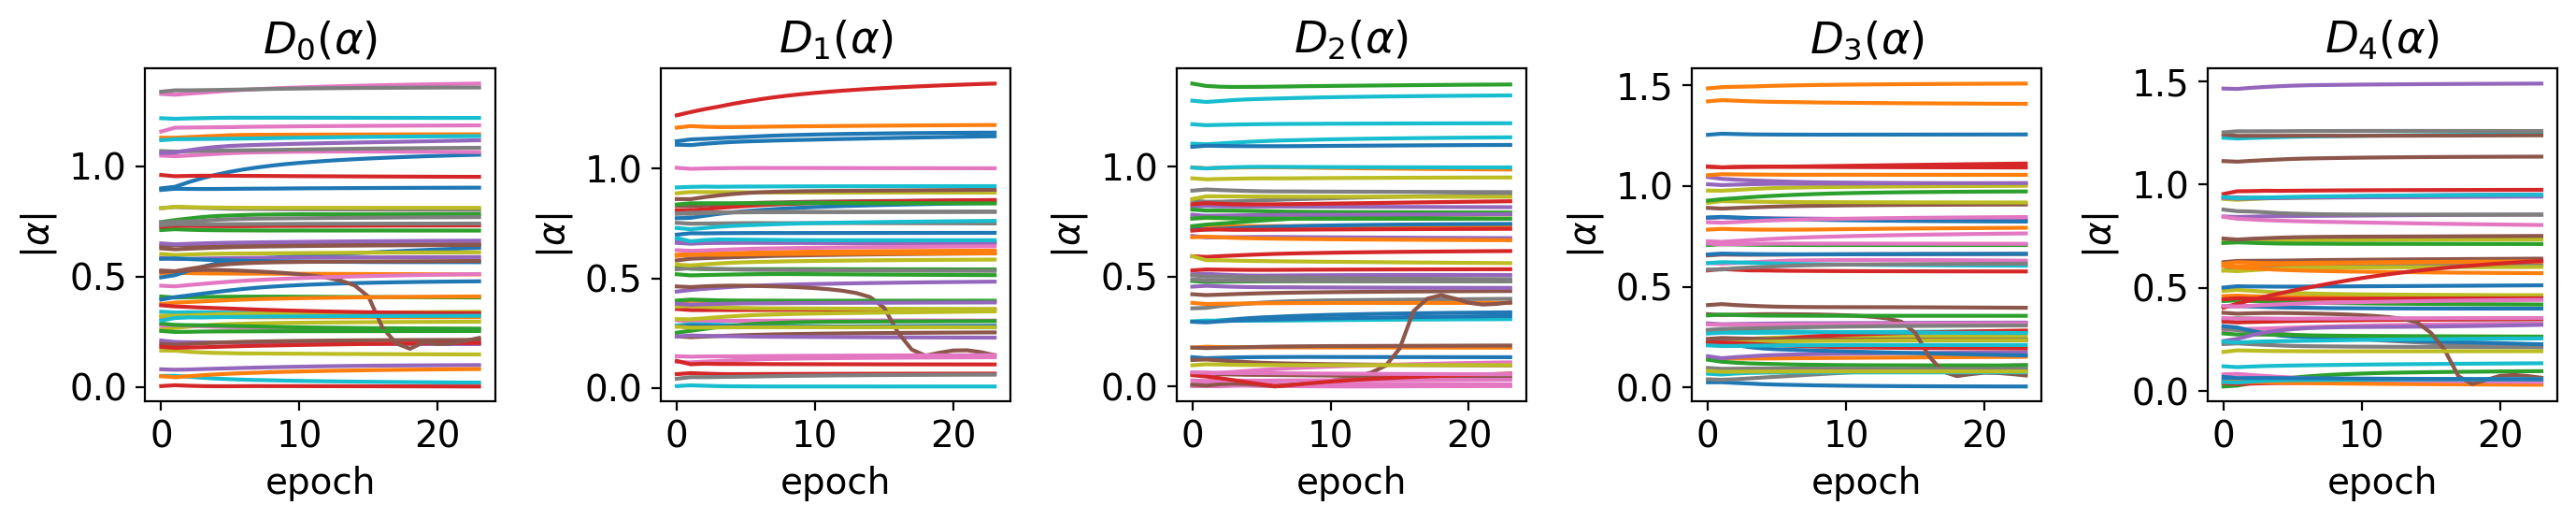

In [21]:
analysis.plot_mag_alphas()

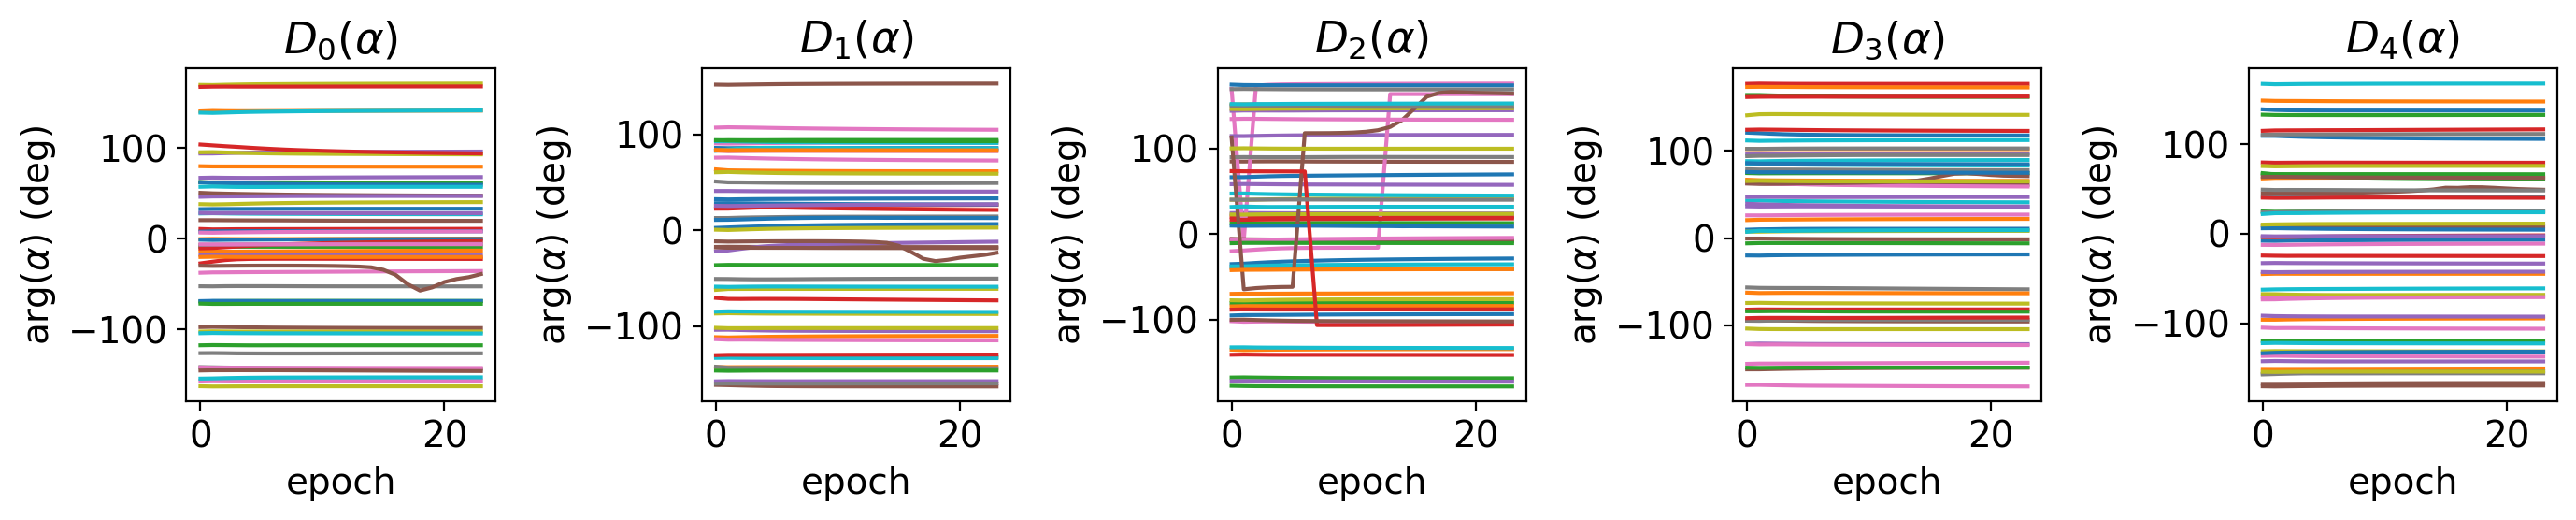

In [22]:
analysis.plot_phase_alphas()

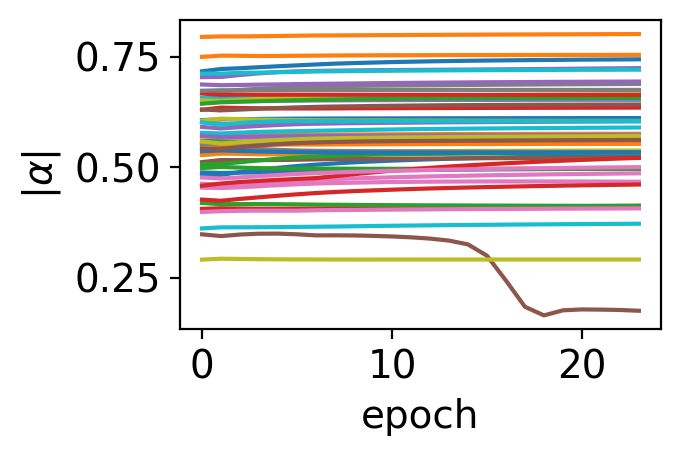

In [23]:
analysis.plot_average_magnitude_alpha()

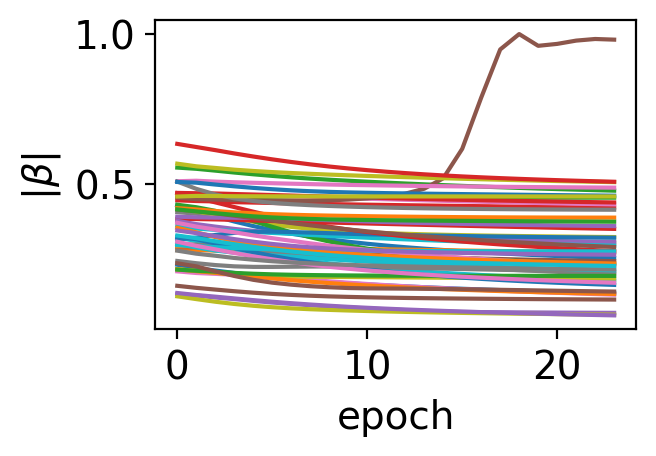

In [24]:
analysis.plot_average_magnitude_beta()

In [ ]:
analysis.data[analysis.timestamps[-1]]

In [ ]:
plt.figure(figsize=(8,6))
if len(all_fids.shape)>1:
    for fids in all_fids:
        plt.semilogy(1-fids)
else:
    plt.semilogy(1-all_fids)
plt.xlabel('epoch')
plt.ylabel('infidelity')
plt.title("100x batch optimization")

In [ ]:
opt.print_info()

In [ ]:
betas, alphas, phis, thetas = opt.get_numpy_vars()

In [ ]:
betas.T.shape

In [ ]:
fids = opt.batch_state_fidelities(opt.betas_rho, opt.betas_angle, opt.alphas_rho, opt.alphas_angle, opt.phis, opt.thetas)

In [ ]:
max_idx = tf.argmax(fids)[0,0].numpy()
max_idx

In [ ]:
fids[max_idx]

In [ ]:
betas[max_idx]

In [ ]:
with tf.device("XLA_GPU:0"):
    a = tf.constant(1.0)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
tf.config.list_physical_devices()

In [ ]:
chi_ab = 2*np.pi*1e-9*10

In [ ]:
chi_ab

In [ ]:
nbar = 1/(4*chi_ab*1000)
nbar

In [ ]:
np.sqrt(nbar)

In [ ]:
np.sqrt(400.0)

In [ ]:
import h5py

In [ ]:
data = np.array([1.0,2.0,3.0])
with h5py.File('test.h5', "w") as f:
    fidelities = f.create_dataset("fidelities", data = data, maxshape=(None,))

In [ ]:
with h5py.File('test.h5', "a") as f:
    f['fidelities'].resize(4, axis=0)
    f['fidelities'][-1] = 4.0

In [ ]:
fs_MHz = np.linspace(0,0.2,201)
omegas_MRadps = 2*np.pi*fs_MHz
tau_us = 10
argument = omegas_MRadps*tau_us/2/np.pi
y = np.sinc(argument)**2


In [ ]:
plt.figure(figsize=(4,3),dpi=200)
plt.plot(fs_MHz*1e3, y, label='tau=10us')
plt.xlabel('KHz')
plt.ylabel('F')
plt.legend(frameon=False)